# Install Optuna

In [ ]:
!pip install optuna

# Import Libs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
import optuna
import xgboost as xgb

from tabulate import tabulate
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Dataset

In [3]:
df = pd.read_csv('car_price_dataset.csv')
df.shape

(10000, 10)

## Amostra de 30%

In [4]:
df_amostra = df.sample(frac=0.3, random_state=42)
df_amostra.shape

(3000, 10)

In [5]:
df_amostra.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
6252,BMW,3 Series,2005,1.2,Diesel,Manual,257760,5,5,2000
4684,Volkswagen,Golf,2013,2.9,Hybrid,Automatic,111790,5,3,11164
1731,Toyota,RAV4,2011,5.0,Hybrid,Automatic,13473,5,4,14630
4742,Mercedes,E-Class,2007,3.8,Diesel,Manual,133298,4,5,7334
4521,Honda,Civic,2012,1.3,Petrol,Automatic,18611,3,5,10127


In [6]:
df_amostra.tail()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
8014,Hyundai,Tucson,2011,3.2,Electric,Manual,139866,5,3,9802
1074,Hyundai,Elantra,2005,1.8,Hybrid,Automatic,263796,3,5,4624
3063,Volkswagen,Tiguan,2015,3.2,Petrol,Semi-Automatic,204013,4,5,7719
6487,Hyundai,Tucson,2016,2.4,Diesel,Automatic,86029,5,5,11079
4705,Chevrolet,Impala,2018,3.5,Electric,Semi-Automatic,34705,3,2,14305


In [7]:
df_amostra.describe()

,Year,Engine_Size,Mileage,Doors,Owner_Count,Price
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,2011.591333,3.018967,147334.350333,3.489667,3.017000,8960.708667
std,6.824064,1.134707,85412.620530,1.110993,1.425268,3066.967585
min,2000.000000,1.000000,74.000000,2.000000,1.000000,2000.000000
25%,2006.000000,2.000000,75544.750000,3.000000,2.000000,6770.000000
50%,2012.000000,3.000000,145359.500000,3.000000,3.000000,9055.000000
75%,2017.000000,4.000000,220159.500000,4.000000,4.000000,11185.750000
max,2023.000000,5.000000,299872.000000,5.000000,5.000000,17719.000000


In [8]:
df_amostra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 6252 to 4705
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         3000 non-null   object 
 1   Model         3000 non-null   object 
 2   Year          3000 non-null   int64  
 3   Engine_Size   3000 non-null   float64
 4   Fuel_Type     3000 non-null   object 
 5   Transmission  3000 non-null   object 
 6   Mileage       3000 non-null   int64  
 7   Doors         3000 non-null   int64  
 8   Owner_Count   3000 non-null   int64  
 9   Price         3000 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 257.8+ KB


In [9]:
df_amostra.dtypes

,0
Brand,object
Model,object
Year,int64
Engine_Size,float64
Fuel_Type,object
Transmission,object
Mileage,int64
Doors,int64
Owner_Count,int64
Price,int64


## Análise de Dados Ausentes

In [10]:
df_amostra.isnull().sum()

,0
Brand,0
Model,0
Year,0
Engine_Size,0
Fuel_Type,0
Transmission,0
Mileage,0
Doors,0
Owner_Count,0
Price,0


Pode se observar que o dataset já está bastante limpo, sem a ausência de dados, o que nos facilita e melhora a criação do modelo em breve. Caso ele tivesse dados nulos, poderiamos usar algumas técnicas para abordar essa situação.

Para colunas categóricas:

- Tratar como dados "Desconhecidos" ou "Não informados".
- Remover as linhas casos sejam poucos os faltantes.
- Uso de Encoding, como faço, transformando-as em colunas numéricas.

Para colunas numéricas:
- Uso de média, moda, mediana, etc.
- Utilizar certos modelos para prever os valores ausentes.
- Remover as linhas casos sejam poucos os faltantes.

In [11]:
df_amostra.dropna()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
6252,BMW,3 Series,2005,1.2,Diesel,Manual,257760,5,5,2000
4684,Volkswagen,Golf,2013,2.9,Hybrid,Automatic,111790,5,3,11164
1731,Toyota,RAV4,2011,5.0,Hybrid,Automatic,13473,5,4,14630
4742,Mercedes,E-Class,2007,3.8,Diesel,Manual,133298,4,5,7334
4521,Honda,Civic,2012,1.3,Petrol,Automatic,18611,3,5,10127
...,...,...,...,...,...,...,...,...,...,...
8014,Hyundai,Tucson,2011,3.2,Electric,Manual,139866,5,3,9802
1074,Hyundai,Elantra,2005,1.8,Hybrid,Automatic,263796,3,5,4624
3063,Volkswagen,Tiguan,2015,3.2,Petrol,Semi-Automatic,204013,4,5,7719
6487,Hyundai,Tucson,2016,2.4,Diesel,Automatic,86029,5,5,11079


In [12]:
df_amostra.columns

Index(['Brand', 'Model', 'Year', 'Engine_Size', 'Fuel_Type', 'Transmission',
       'Mileage', 'Doors', 'Owner_Count', 'Price'],
      dtype='object')

## EDA

In [13]:
df_amostra.head(5)

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
6252,BMW,3 Series,2005,1.2,Diesel,Manual,257760,5,5,2000
4684,Volkswagen,Golf,2013,2.9,Hybrid,Automatic,111790,5,3,11164
1731,Toyota,RAV4,2011,5.0,Hybrid,Automatic,13473,5,4,14630
4742,Mercedes,E-Class,2007,3.8,Diesel,Manual,133298,4,5,7334
4521,Honda,Civic,2012,1.3,Petrol,Automatic,18611,3,5,10127


Analisando abaixo a quantidade de carros vendidos por ano para podermos observar se existe algum ano de maior influência.

In [14]:
# Conta quantos carros existem em cada ano e transforma em um DataFrame
carros_por_ano = df_amostra["Year"].value_counts().reset_index()

# Renomeia as colunas para facilitar a leitura
carros_por_ano.columns = ["Ano", "Quantidade"]

# Ordena os anos em ordem crescente
carros_por_ano = carros_por_ano.sort_values(by="Ano", ascending=True).reset_index(drop=True)

# Tabela
carros_por_ano

,Ano,Quantidade
0,2000,107
1,2001,122
2,2002,136
3,2003,113
4,2004,113
5,2005,131
6,2006,128
7,2007,126
8,2008,109
9,2009,125


In [15]:
# Ordenar os preços em ordem decrescente e exibir os preços mais altos
maior_preco_10 = df_amostra[['Price']].sort_values(by='Price', ascending=False).head(10)

# Exibir carros mais caros
maior_preco_10

,Price
9834,17719
9731,17630
6123,17614
3319,17386
3231,17078
8706,17054
9766,16630
9582,16601
1310,16544
3578,16500


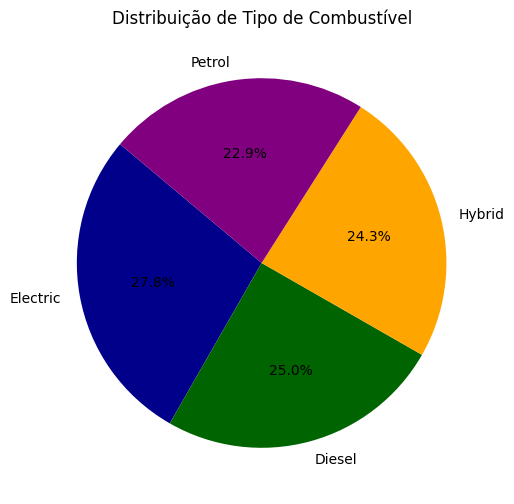

In [16]:
fuel_counts = df_amostra["Fuel_Type"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(fuel_counts, labels=fuel_counts.index, autopct='%1.1f%%', startangle=140, colors=["darkblue", "darkgreen", "orange", "purple"])
plt.title("Distribuição de Tipo de Combustível")
plt.show()

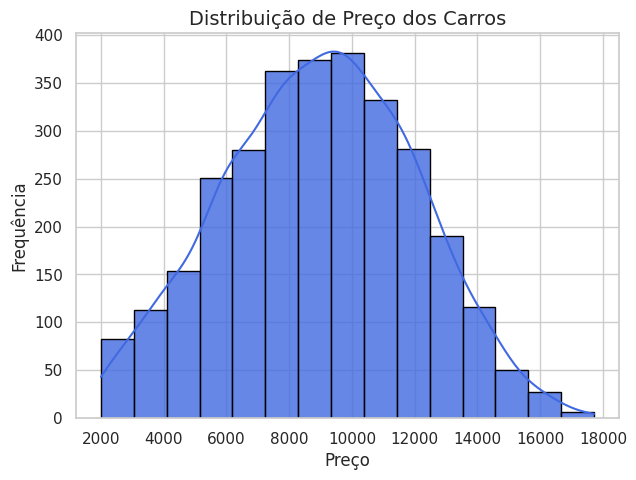

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.histplot(df_amostra["Price"], bins=15, kde=True, color="royalblue", edgecolor="black", alpha=0.8)
plt.xlabel("Preço", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.title("Distribuição de Preço dos Carros", fontsize=14)
plt.show()

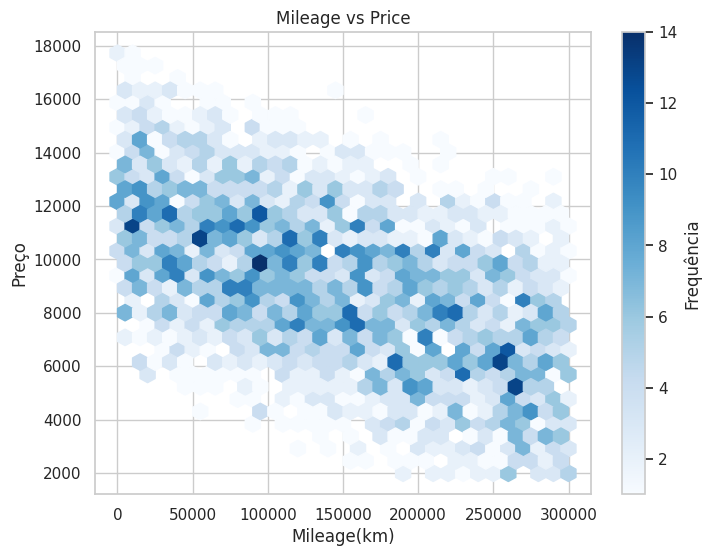

In [18]:
plt.figure(figsize=(8,6))
plt.hexbin(df_amostra["Mileage"], df_amostra["Price"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(label="Frequência")
plt.xlabel("Mileage(km)")
plt.ylabel("Preço")
plt.title("Mileage vs Price")
plt.show()

### Identificação de variáveis numéricas e categóricas

In [19]:
var_num = df_amostra.select_dtypes(include=['number']).columns # Identificando variáveis numéricas
var_ctg = df_amostra.select_dtypes(exclude=['number']).columns # Identificando variáveis categóricas

print("Variáveis Numéricas:")
print(var_num)

print("\nVariáveis Categóricas:")
print(var_ctg)

Variáveis Numéricas:
Index(['Year', 'Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'Price'], dtype='object')

Variáveis Categóricas:
Index(['Brand', 'Model', 'Fuel_Type', 'Transmission'], dtype='object')


### Análise das Variáveis Numéricas

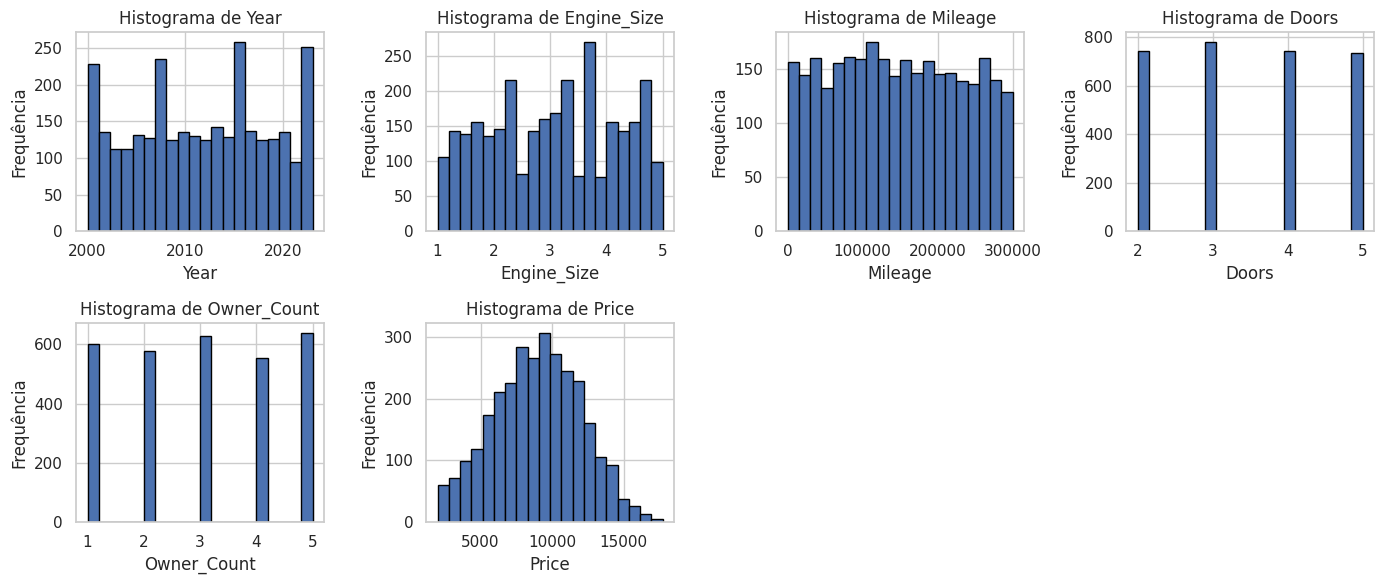

In [20]:
col_num = len(var_num)
linhas_num = math.ceil(col_num / 3)
plt.figure(figsize=(14, linhas_num * 3))

# Criando os histogramas
for i, column in enumerate(var_num, 1):
    plt.subplot(linhas_num, 4, i)
    df_amostra[column].hist(bins=20, edgecolor='black')
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

### Correlação de Pearson para Variáveis Numéricas

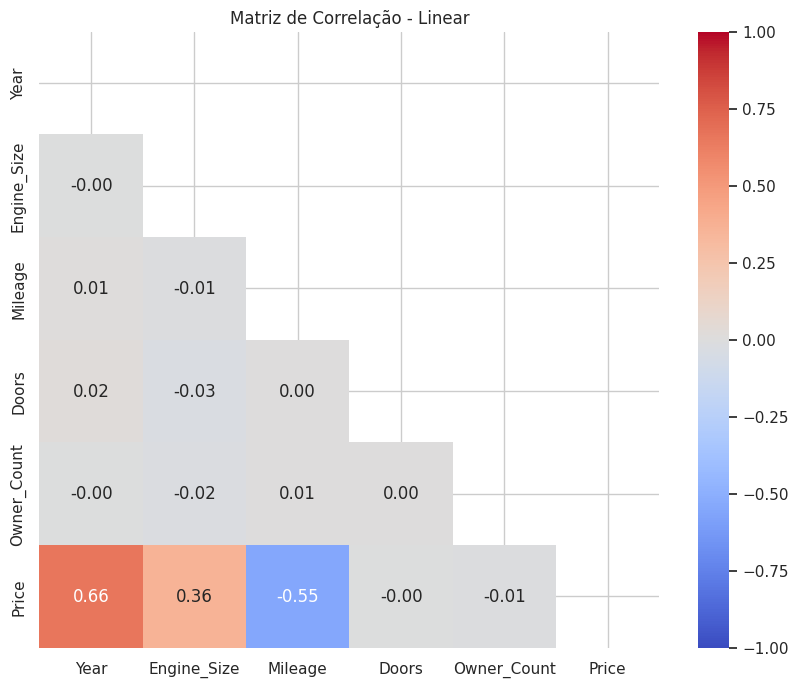

In [21]:
plt.figure(figsize=(10, 8))

correlation_matrix_pearson = df_amostra.corr(method='pearson', numeric_only=True)
mask = np.triu(np.ones_like(correlation_matrix_pearson, dtype=bool))
sns.heatmap(correlation_matrix_pearson, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, vmin=-1, vmax=1)

plt.title('Matriz de Correlação - Linear')
plt.show()

### Análise das Variáveis Categóricas

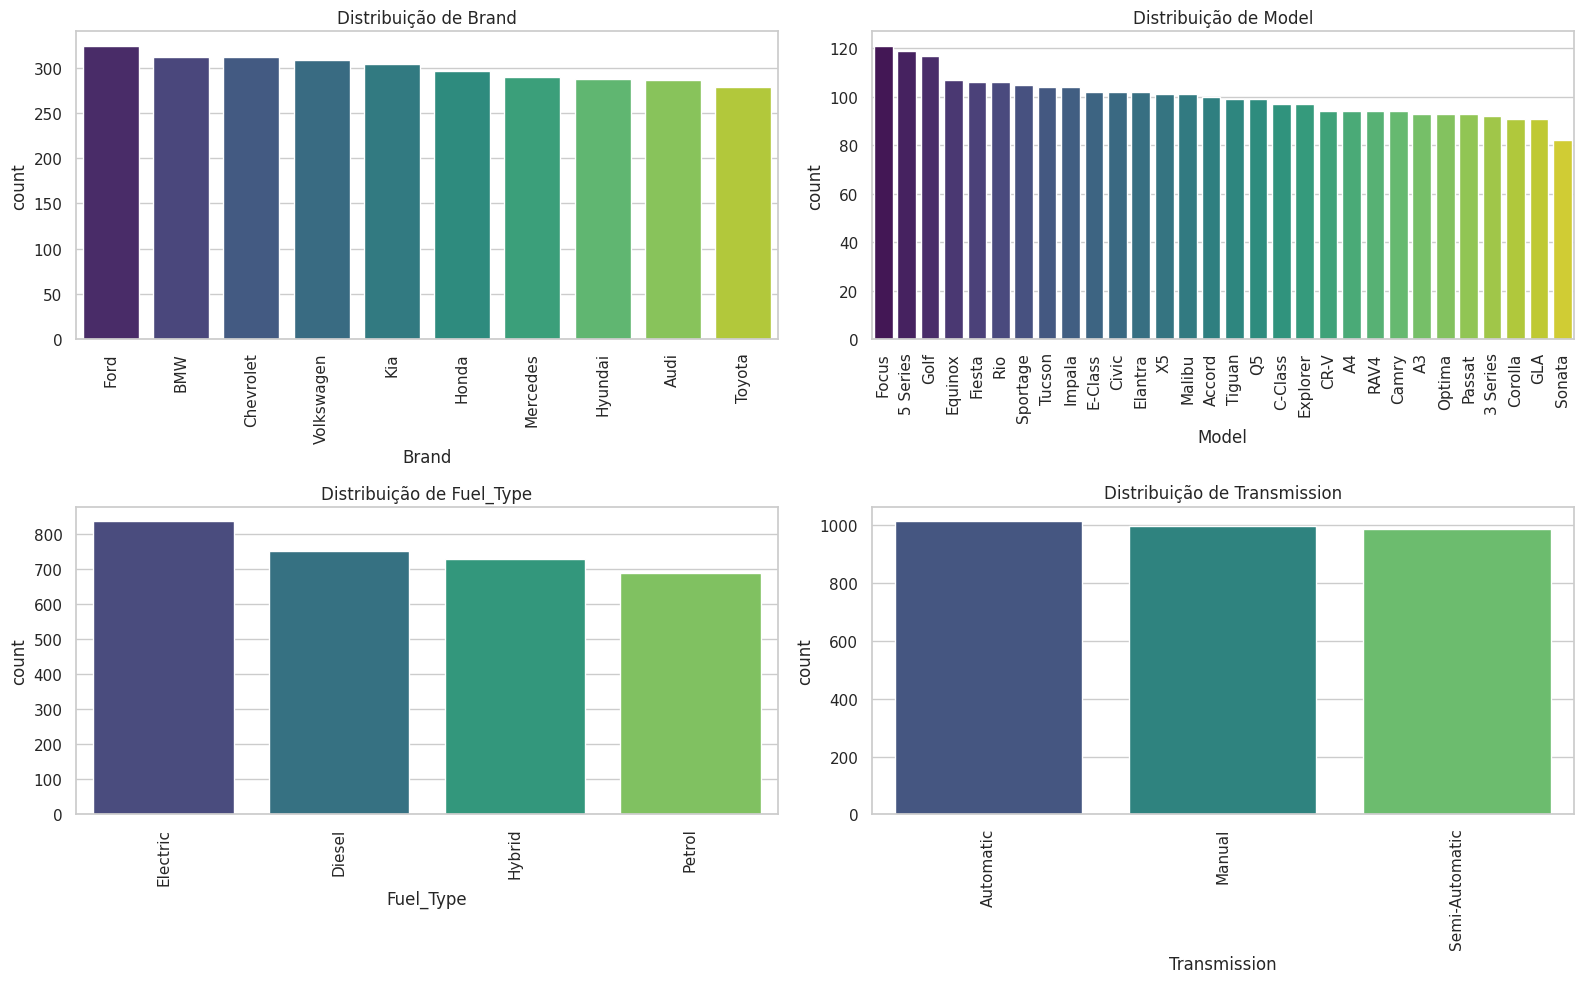

In [22]:
fig, axes = plt.subplots(len(var_ctg) // 2 + len(var_ctg) % 2, 2, figsize=(16, (len(var_ctg) // 2 + len(var_ctg) % 2) * 5))

# Ajustar o eixo para quando a quantidade de gráficos for ímpar
for i, col in enumerate(var_ctg):
    row = i // 2
    col_idx = i % 2
    # Gráfico de barras (contagem de ocorrências)
    sns.countplot(data=df_amostra, x=col, ax=axes[row, col_idx], order=df_amostra[col].value_counts().index, palette="viridis")
    axes[row, col_idx].set_title(f"Distribuição de {col}")
    axes[row, col_idx].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Correlação das Variáveis Categóricas

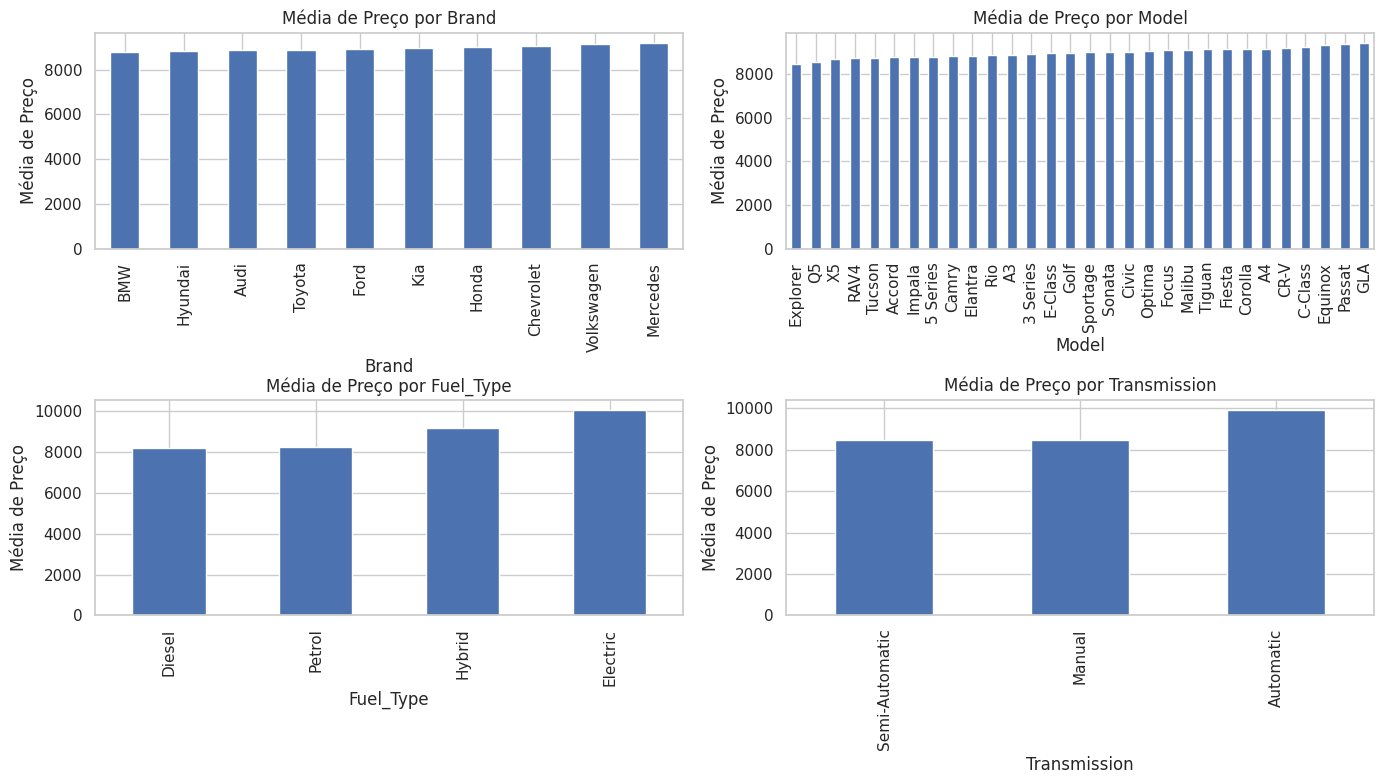

In [23]:
col_num = len(var_ctg)
linhas_num = (col_num // 2)
fig, axes = plt.subplots(linhas_num, 2, figsize=(14, linhas_num * 4))

axes = axes.flatten()

for i, col in enumerate(var_ctg):
    df_amostra.groupby(col)['Price'].mean().sort_values().plot(
        kind='bar', ax=axes[i], title=f'Média de Preço por {col}'
    )
    axes[i].set_ylabel('Média de Preço')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
plt.show()

#### Teste ANOVA

In [24]:
df_anova = df_amostra.copy()
df_anova.head(1)

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
6252,BMW,3 Series,2005,1.2,Diesel,Manual,257760,5,5,2000


In [25]:
# Loop para realizar a ANOVA para cada variável categórica
for col in var_ctg:

    # Realizando a ANOVA entre a variável categórica e a variável numérica
    grouped_data = [df_anova[df_anova[col] == cat]["Price"] for cat in df_anova[col].unique()]

    # Aplicando a ANOVA
    f_stat, p_val = stats.f_oneway(*grouped_data)

    # Saída dos valores
    print(f"P-valor da ANOVA para {col}: {p_val:.4f}")

P-valor da ANOVA para Brand: 0.8469
P-valor da ANOVA para Model: 0.9768
P-valor da ANOVA para Fuel_Type: 0.0000
P-valor da ANOVA para Transmission: 0.0000


# Modelagem

In [26]:
df_modelo = df_amostra.copy()
df_modelo.head(1)

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
6252,BMW,3 Series,2005,1.2,Diesel,Manual,257760,5,5,2000


In [27]:
le = LabelEncoder()
for col in df_modelo.select_dtypes(include=["object"]).columns:
    df_modelo[col] = le.fit_transform(df_modelo[col])

In [28]:
X = df_modelo.drop(columns=["Price"])
y = df_modelo["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
# Apresentando os valores para cada conjunto dividido
print("X_train:\n", X_train.shape)
print("\nX_test:\n", X_test.shape)
print("\ny_train:\n", y_train.shape)
print("\ny_test:\n", y_test.shape)

X_train:
 (2100, 9)

X_test:
 (900, 9)

y_train:
 (2100,)

y_test:
 (900,)


In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2100 entries, 2534 to 9115
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         2100 non-null   int64  
 1   Model         2100 non-null   int64  
 2   Year          2100 non-null   int64  
 3   Engine_Size   2100 non-null   float64
 4   Fuel_Type     2100 non-null   int64  
 5   Transmission  2100 non-null   int64  
 6   Mileage       2100 non-null   int64  
 7   Doors         2100 non-null   int64  
 8   Owner_Count   2100 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 164.1 KB


- Agora que todas nossas variáveis categóricas já foram convertidas para números e conferidas, podemos assim progredir para a modelagem.

## Normalizar os dados

In [31]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinamento de Diversos Modelos

In [32]:
# Lista de modelos que serão usados para o treinamento
modelos = [
    (LinearRegression(), "Linear Regression"),
    (GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42), "Gradient Boosting"),
    (RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), "Random Forest"),
    (XGBRegressor(n_estimators=50, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0), "XGBoost")
]

In [33]:
# Lista para armazenar os resultados
resultados = []

# Função de treinamento e avaliação
def avaliacao_e_treino(model, model_name, X_train, X_test, y_train, y_test):
    # Treinando o modelo
    model.fit(X_train, y_train)

    # Fazendo predições no conjunto de teste
    y_pred = model.predict(X_test)

    # Calculando as métricas de avaliação
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Armazenando os resultados
    resultados.append({
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

In [34]:
# Treinar modelos com barra de progresso
for model, model_name in tqdm(modelos, desc="Training Models", unit="model"):
    avaliacao_e_treino(model, model_name, X_train, X_test, y_train, y_test)

# Converter os resultados para um DataFrame
df_resultados = pd.DataFrame(resultados)

# Exibir os resultados
df_resultados

Training Models: 100%|██████████| 4/4 [00:01<00:00,  3.01model/s]


,Model,MAE,RMSE,R2
0,Linear Regression,815.887714,926.111336,0.914906
1,Gradient Boosting,478.396933,601.213679,0.964138
2,Random Forest,655.062564,812.980731,0.934426
3,XGBoost,334.200409,424.953104,0.982083


## Tuning do Modelo

In [35]:
# Função para otimizar os hiperparâmetros
def otimizar(trial):
    parametros = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0)
    }

    # Criar o modelo XGBoost com os parâmetros sugeridos
    model = XGBRegressor(**parametros, random_state=42, verbosity=0)

    # Treinar o modelo com os dados
    model.fit(X_train, y_train)

    # Fazer as predições e calcular o MAE para avaliação
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    return mae  # Retornar a métrica que será minimizada

In [36]:
# Rodar a otimização
study = optuna.create_study(direction='minimize')
study.optimize(otimizar, n_trials=10)  # Testa 10 combinações diferentes

[I 2025-02-13 14:22:35,610] A new study created in memory with name: no-name-e16251e1-b56b-473a-898c-c138c991227a
[I 2025-02-13 14:22:35,923] Trial 0 finished with value: 588.0580444335938 and parameters: {'n_estimators': 58, 'max_depth': 5, 'learning_rate': 0.04982882473615491, 'subsample': 0.7171848490820226, 'colsample_bytree': 0.8767305651598684, 'gamma': 0.81697564156203}. Best is trial 0 with value: 588.0580444335938.
[I 2025-02-13 14:22:36,986] Trial 1 finished with value: 343.06884765625 and parameters: {'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.09627192767625989, 'subsample': 0.6107406765869188, 'colsample_bytree': 0.8592054289116331, 'gamma': 0.6070587992891994}. Best is trial 1 with value: 343.06884765625.
[I 2025-02-13 14:22:37,468] Trial 2 finished with value: 533.6365356445312 and parameters: {'n_estimators': 91, 'max_depth': 5, 'learning_rate': 0.03383894866222492, 'subsample': 0.7186532459429218, 'colsample_bytree': 0.9760879738919368, 'gamma': 0.6375844191

In [37]:
# Melhor conjunto de hiperparâmetros encontrado
print("Melhores hiperparâmetros:", study.best_params)
print("Melhor MAE:", study.best_value)

Melhores hiperparâmetros: {'n_estimators': 79, 'max_depth': 6, 'learning_rate': 0.0891511255589184, 'subsample': 0.7103248713897885, 'colsample_bytree': 0.9252336974998503, 'gamma': 0.273768187593009}
Melhor MAE: 261.1187744140625


In [38]:
# Treinando o modelo final com os melhores hiperparâmetros
best_params = study.best_params
final_model = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

# Avaliação no conjunto de teste
y_test_pred = final_model.predict(X_test)

## Métricas de Avaliação

In [39]:
# Calcular métricas no conjunto de teste
final_mae = mean_absolute_error(y_test, y_test_pred)
final_mse = mean_squared_error(y_test, y_test_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, y_test_pred)

# Exibir as métricas
print("Métricas no Conjunto de Teste:")
print(f"MAE  (Mean Absolute Error): {final_mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {final_rmse:.2f}")
print(f"R²   (Coeficiente de Determinação): {final_r2:.4f}")

Métricas no Conjunto de Teste:
MAE  (Mean Absolute Error): 261.12
RMSE (Root Mean Squared Error): 333.24
R²   (Coeficiente de Determinação): 0.9890


## XAI

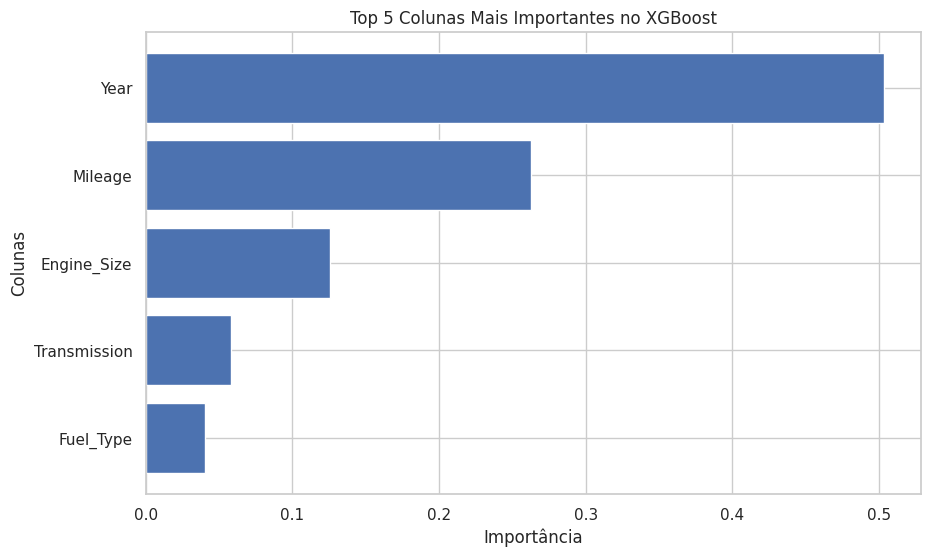

In [40]:
# Obtendo a importância das features do modelo XGBoost
feature_importance = model.feature_importances_

# Garantir que temos os nomes das features originais (após o pré-processamento)
feature_names = X.columns

# DataFrame com as importâncias das features
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plotar as 5 features mais importantes
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"].head(5), importance_df["Importance"].head(5))
plt.xlabel("Importância")
plt.ylabel("Colunas")
plt.title("Top 5 Colunas Mais Importantes no XGBoost")
plt.gca().invert_yaxis()  # Inverter o eixo Y para exibir a feature mais importante no topo
plt.show()

# Teste para Evitar Data Leakage

In [41]:
# Carregando novos dados
df_resto = df.drop(df_modelo.index)
df_amostra_2 = df_resto.sample(frac=0.2, random_state=99)

print("Primeira amostra:", df_modelo.shape)
print("Segunda amostra:", df_amostra_2.shape)

Primeira amostra: (3000, 10)
Segunda amostra: (1400, 10)


In [42]:
le = LabelEncoder()
for col in df_modelo.select_dtypes(include=["object"]).columns:
    df_amostra_2[col] = le.fit_transform(df_amostra_2[col])

Separação para Treino e Teste, e Seleção da Variável Alvo

In [43]:
X_data2 = df_amostra_2.drop(columns=['Price'])
y_data2 = df_amostra_2['Price']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.3, random_state=42)

Normalização dos Dados

In [44]:
# Normalizar os dados mantendo o índice
scaler = MinMaxScaler()
X_train_2 = pd.DataFrame(scaler.fit_transform(X_train_2),
                         index=X_train_2.index,
                         columns=X_train_2.columns)

X_test_2 = pd.DataFrame(scaler.transform(X_test_2),
                        index=X_test_2.index,
                        columns=X_test_2.columns)

Tuning do Modelo

In [45]:
# Função para otimizar os hiperparâmetros
def otimizar_2(trial):
    parametros = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0)
    }

    # Criar o modelo XGBoost com os parâmetros sugeridos
    model_2 = XGBRegressor(**parametros, random_state=42, verbosity=0)

    # Treinar o modelo com os dados
    model_2.fit(X_train_2, y_train_2)

    # Fazer as predições e calcular o MAE para avaliação
    y_pred_2 = model_2.predict(X_test_2)
    mae_2 = mean_absolute_error(y_test_2, y_pred_2)

    return mae_2  # Retornar a métrica que será minimizada

In [46]:
# Rodar a otimização
study = optuna.create_study(direction='minimize')
study.optimize(otimizar_2, n_trials=10)  # Testa 10 combinações diferentes

[I 2025-02-13 14:22:43,185] A new study created in memory with name: no-name-e6d52965-0556-4476-9d70-9047f33ebd94
[I 2025-02-13 14:22:46,512] Trial 0 finished with value: 969.7544555664062 and parameters: {'n_estimators': 58, 'max_depth': 10, 'learning_rate': 0.04034408761786236, 'subsample': 0.8379031913972019, 'colsample_bytree': 0.7125254896984617, 'gamma': 0.9197510606826645}. Best is trial 0 with value: 969.7544555664062.
[I 2025-02-13 14:22:46,669] Trial 1 finished with value: 298.0230407714844 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05783275084147199, 'subsample': 0.7275813445587923, 'colsample_bytree': 0.7343626629503041, 'gamma': 0.8461209674770203}. Best is trial 1 with value: 298.0230407714844.
[I 2025-02-13 14:22:47,521] Trial 2 finished with value: 771.907470703125 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.0622183085232366, 'subsample': 0.6842837339005052, 'colsample_bytree': 0.7645670571362987, 'gamma': 0.883

Métricas de Avaliação

In [47]:
# Melhor conjunto de hiperparâmetros encontrado
print("Melhores hiperparâmetros:", study.best_params)
print("Melhor MAE:", study.best_value)

Melhores hiperparâmetros: {'n_estimators': 75, 'max_depth': 4, 'learning_rate': 0.09594781274989686, 'subsample': 0.9206606446692147, 'colsample_bytree': 0.9265013427078722, 'gamma': 0.45188226341106974}
Melhor MAE: 265.04669189453125


In [48]:
# Treinando o modelo final com os melhores hiperparâmetros
best_params_2 = study.best_params
final_model_2 = XGBRegressor(**best_params_2, random_state=42, n_jobs=-1)
final_model_2.fit(X_train, y_train)

# Avaliação no conjunto de teste
y_test_pred_2 = final_model_2.predict(X_test)

In [49]:
# Calcular métricas
final_mae_2 = mean_absolute_error(y_test_2, y_test_pred_2)
final_mse_2 = mean_squared_error(y_test_2, y_test_pred_2)
final_rmse_2 = np.sqrt(final_mse_2)
final_r2_2 = r2_score(y_test_2, y_test_pred_2)

# Exibir as métricas
print("Métricas no Conjunto de Teste:")
print(f"MAE  (Mean Absolute Error): {final_mae_2:.2f}")
print(f"RMSE (Root Mean Squared Error): {final_rmse_2:.2f}")
print(f"R²   (Coeficiente de Determinação): {final_r2_2:.4f}")

Métricas no Conjunto de Teste:
MAE  (Mean Absolute Error): 265.05
RMSE (Root Mean Squared Error): 331.91
R²   (Coeficiente de Determinação): 0.9891


In [50]:
X_test_2 = pd.DataFrame(X_test_2, index=X_test_2.index, columns=X_test_2.columns)

Comparando o Preço Real e o Preço Previsto

In [52]:
# Exibindo as previsões comparadas
df_amostra_2 = df.loc[X_test_2.index]
resultados = df_amostra_2.copy()
resultados['Predicted_Price'] = y_test_pred_2
resultados[['Brand', 'Model', 'Year', 'Price', 'Predicted_Price']].head(15)

,Brand,Model,Year,Price,Predicted_Price
2697,BMW,5 Series,2017,9109,8549.639648
6871,Volkswagen,Tiguan,2017,8102,8510.992188
3487,BMW,5 Series,2017,11213,11226.527344
92,Mercedes,E-Class,2011,3975,4151.838867
9537,Chevrolet,Equinox,2012,9138,9292.326172
3205,Toyota,RAV4,2016,12650,13059.171875
6641,BMW,X5,2019,13196,12872.767578
8909,Volkswagen,Passat,2009,8645,9000.334961
2884,Ford,Explorer,2009,5899,6354.651367
7173,Hyundai,Elantra,2019,6000,6101.361816


# FIM